In [1]:
import sys
sys.path.append('./models/')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from data_loader import Dataset,Options
import models.unet_normals as unet
from tensorboardX import SummaryWriter
import OpenEXR, Imath

### Setup Options
Set the various parameters:
- dataroot: The folder where the training data is stored
- file_list: List of filenames of images for training
- batchSize: Batch size for model
- shuffle: If true, will shuffle the dataset
- phase: If 'train', then it's in training mode.
- num_epochs: Number of epochs to train the model for
- imsize: Dimensions of the image (square)
- num_classes: Num of classes in the output
- gpu: Which GPU device to use
- logs_path: The path where the log files (tensorboard) will be saved.

In [2]:
class OPT():
    def __init__(self):
        self.dataroot = './data/'
        self.file_list = './data/datalist'
        self.batchSize = 24
        self.shuffle = True
        self.phase = 'train'
        self.num_epochs = 1000
        self.imsize = 224
        self.num_classes = int(3)
        self.gpu = '0'
        self.logs_path = 'logs/exp4'
        self.use_pretrained = False

opt = OPT()

### Setup logging and dataloaders

In [3]:
###################### Options #############################
phase = opt.phase
device = torch.device("cuda:"+ opt.gpu if torch.cuda.is_available() else "cpu")

###################### TensorBoardX #############################
if os.path.exists(opt.logs_path):
    raise Exception('The folder \"{}\" already exists! Define a new log path or delete old contents.'.format(opt.logs_path))
    
writer = SummaryWriter(opt.logs_path, comment='create-graph')
graph_created = False

###################### DataLoader #############################
dataloader = Dataset(opt)


shuffling the dataset


### Create the model
We use a UNet model. The last few layers of this model are modified to return a 3 channel image, containing the x,y,z values of surface normal vectors.

In [4]:
###################### ModelBuilder #############################
model = unet.Unet(num_classes=opt.num_classes)

# Load weights from checkpoint
if (opt.use_pretrained == True):
    checkpoint_path = 'logs/exp2/checkpoints/checkpoint.pth'
    model.load_state_dict(torch.load(checkpoint_path))

model = model.to(device)
model.train()

###################### Setup Optimazation #############################
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

###################### Loss fuction #############################
'''
@input: The 2 vectors whose cosine loss is to be calculated
The dimensions of the matrices are expected to be (batchSize, 3, imsize, imsize). 

@return: 
elementwise_mean: will return the sum of all losses divided by num of elements
none: The loss will be calculated to be of size (batchSize, imsize, imsize) containing cosine loss of each pixel
'''
def loss_fn(input_vec, target_vec, reduction='elementwise_mean'):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    loss_val = 1.0 - cos(input_vec, target_vec)
    if (reduction=='elementwise_mean'):
        return torch.mean(loss_val)
    elif (reduction=='none'):
        return loss_val
    else:
        raise Exception('Warning! The reduction is invalid. Please use \'elementwise_mean\' or \'none\''.format())


### Train the model


In [5]:
###################### Train Model #############################
# Calculate total iter_num
total_iter_num = 0

for epoch in range(opt.num_epochs):
    print('Epoch {}/{}'.format(epoch, opt.num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    running_loss = 0.0
    
    


    # Iterate over data.
    for i in range(int(dataloader.size()/opt.batchSize)):
        total_iter_num += 1
        
        # Get data
        inputs, labels =  dataloader.get_batch()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #ToDo: get labels into correct format
        
        ## Create Graph ##
        if graph_created == False:
            graph_created = True
            writer.add_graph(model, inputs, verbose=False)
        
        # Forward + Backward Prop
        optimizer.zero_grad()
        torch.set_grad_enabled(True)
        normal_vectors = model(inputs)
        normal_vectors_norm = nn.functional.normalize(normal_vectors, p=2, dim=1)
        
        loss = loss_fn(normal_vectors_norm, labels, reduction='elementwise_mean')
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        writer.add_scalar('running_loss', running_loss, total_iter_num)
        writer.add_scalar('loss', loss.item(), total_iter_num)

    epoch_loss = running_loss / (dataloader.size()/opt.batchSize)
    print('{} Loss: {:.4f}'.format(phase, epoch_loss))
    
    # Save the model checkpoint
    directory = opt.logs_path+'/checkpoints/'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    if (epoch % 25 == 0):
        filename = opt.logs_path + '/checkpoints/checkpoint-ep_{}-iter_{}.pth'.format(epoch,i)
        torch.save(model.state_dict(), filename)

# Save final Checkpoint
filename = opt.logs_path + '/checkpoints/checkpoint.pth'
torch.save(model.state_dict(), filename)


Epoch 0/999
----------


/home/shrek/anaconda3/envs/pytorch-cuda9.0/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/shrek/anaconda3/envs/pytorch-cuda9.0/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


train Loss: 1.1442
Epoch 1/999
----------
shuffling the dataset
train Loss: 0.2863
Epoch 2/999
----------
shuffling the dataset
train Loss: 0.1843
Epoch 3/999
----------
shuffling the dataset
train Loss: 0.1750
Epoch 4/999
----------
shuffling the dataset
train Loss: 0.1766
Epoch 5/999
----------
shuffling the dataset
train Loss: 0.1737
Epoch 6/999
----------
shuffling the dataset
train Loss: 0.1706
Epoch 7/999
----------
shuffling the dataset
train Loss: 0.1645
Epoch 8/999
----------
shuffling the dataset
train Loss: 0.1860
Epoch 9/999
----------
shuffling the dataset
train Loss: 0.1782
Epoch 10/999
----------
shuffling the dataset
train Loss: 0.1632
Epoch 11/999
----------
shuffling the dataset
train Loss: 0.1812
Epoch 12/999
----------
shuffling the dataset
train Loss: 0.1602
Epoch 13/999
----------
shuffling the dataset
train Loss: 0.1589
Epoch 14/999
----------
shuffling the dataset
train Loss: 0.1704
Epoch 15/999
----------
shuffling the dataset
train Loss: 0.1858
Epoch 16/999
--

shuffling the dataset
train Loss: 0.1763
Epoch 129/999
----------
shuffling the dataset
train Loss: 0.1621
Epoch 130/999
----------
shuffling the dataset
train Loss: 0.1642
Epoch 131/999
----------
shuffling the dataset
train Loss: 0.1462
Epoch 132/999
----------
shuffling the dataset
train Loss: 0.1806
Epoch 133/999
----------
shuffling the dataset
train Loss: 0.1424
Epoch 134/999
----------
shuffling the dataset
train Loss: 0.1855
Epoch 135/999
----------
shuffling the dataset
train Loss: 0.1598
Epoch 136/999
----------
shuffling the dataset
train Loss: 0.1671
Epoch 137/999
----------
shuffling the dataset
train Loss: 0.1483
Epoch 138/999
----------
shuffling the dataset
train Loss: 0.1617
Epoch 139/999
----------
shuffling the dataset
train Loss: 0.1432
Epoch 140/999
----------
shuffling the dataset
train Loss: 0.1647
Epoch 141/999
----------
shuffling the dataset
train Loss: 0.1793
Epoch 142/999
----------
shuffling the dataset
train Loss: 0.1849
Epoch 143/999
----------
shuffling 

shuffling the dataset
train Loss: 0.1218
Epoch 255/999
----------
shuffling the dataset
train Loss: 0.1059
Epoch 256/999
----------
shuffling the dataset
train Loss: 0.1161
Epoch 257/999
----------
shuffling the dataset
train Loss: 0.1085
Epoch 258/999
----------
shuffling the dataset
train Loss: 0.1121
Epoch 259/999
----------
shuffling the dataset
train Loss: 0.1143
Epoch 260/999
----------
shuffling the dataset
train Loss: 0.1013
Epoch 261/999
----------
shuffling the dataset
train Loss: 0.1136
Epoch 262/999
----------
shuffling the dataset
train Loss: 0.0920
Epoch 263/999
----------
shuffling the dataset
train Loss: 0.1108
Epoch 264/999
----------
shuffling the dataset
train Loss: 0.0994
Epoch 265/999
----------
shuffling the dataset
train Loss: 0.1074
Epoch 266/999
----------
shuffling the dataset
train Loss: 0.0930
Epoch 267/999
----------
shuffling the dataset
train Loss: 0.1137
Epoch 268/999
----------
shuffling the dataset
train Loss: 0.0842
Epoch 269/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0474
Epoch 381/999
----------
shuffling the dataset
train Loss: 0.0443
Epoch 382/999
----------
shuffling the dataset
train Loss: 0.0433
Epoch 383/999
----------
shuffling the dataset
train Loss: 0.0452
Epoch 384/999
----------
shuffling the dataset
train Loss: 0.0366
Epoch 385/999
----------
shuffling the dataset
train Loss: 0.0447
Epoch 386/999
----------
shuffling the dataset
train Loss: 0.0469
Epoch 387/999
----------
shuffling the dataset
train Loss: 0.0395
Epoch 388/999
----------
shuffling the dataset
train Loss: 0.0391
Epoch 389/999
----------
shuffling the dataset
train Loss: 0.0437
Epoch 390/999
----------
shuffling the dataset
train Loss: 0.0396
Epoch 391/999
----------
shuffling the dataset
train Loss: 0.0393
Epoch 392/999
----------
shuffling the dataset
train Loss: 0.0363
Epoch 393/999
----------
shuffling the dataset
train Loss: 0.0406
Epoch 394/999
----------
shuffling the dataset
train Loss: 0.0493
Epoch 395/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0269
Epoch 507/999
----------
shuffling the dataset
train Loss: 0.0260
Epoch 508/999
----------
shuffling the dataset
train Loss: 0.0228
Epoch 509/999
----------
shuffling the dataset
train Loss: 0.0276
Epoch 510/999
----------
shuffling the dataset
train Loss: 0.0226
Epoch 511/999
----------
shuffling the dataset
train Loss: 0.0257
Epoch 512/999
----------
shuffling the dataset
train Loss: 0.0249
Epoch 513/999
----------
shuffling the dataset
train Loss: 0.0227
Epoch 514/999
----------
shuffling the dataset
train Loss: 0.0252
Epoch 515/999
----------
shuffling the dataset
train Loss: 0.0226
Epoch 516/999
----------
shuffling the dataset
train Loss: 0.0253
Epoch 517/999
----------
shuffling the dataset
train Loss: 0.0247
Epoch 518/999
----------
shuffling the dataset
train Loss: 0.0231
Epoch 519/999
----------
shuffling the dataset
train Loss: 0.0222
Epoch 520/999
----------
shuffling the dataset
train Loss: 0.0206
Epoch 521/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0193
Epoch 633/999
----------
shuffling the dataset
train Loss: 0.0177
Epoch 634/999
----------
shuffling the dataset
train Loss: 0.0199
Epoch 635/999
----------
shuffling the dataset
train Loss: 0.0203
Epoch 636/999
----------
shuffling the dataset
train Loss: 0.0183
Epoch 637/999
----------
shuffling the dataset
train Loss: 0.0167
Epoch 638/999
----------
shuffling the dataset
train Loss: 0.0190
Epoch 639/999
----------
shuffling the dataset
train Loss: 0.0188
Epoch 640/999
----------
shuffling the dataset
train Loss: 0.0181
Epoch 641/999
----------
shuffling the dataset
train Loss: 0.0166
Epoch 642/999
----------
shuffling the dataset
train Loss: 0.0202
Epoch 643/999
----------
shuffling the dataset
train Loss: 0.0150
Epoch 644/999
----------
shuffling the dataset
train Loss: 0.0195
Epoch 645/999
----------
shuffling the dataset
train Loss: 0.0210
Epoch 646/999
----------
shuffling the dataset
train Loss: 0.0173
Epoch 647/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0156
Epoch 759/999
----------
shuffling the dataset
train Loss: 0.0139
Epoch 760/999
----------
shuffling the dataset
train Loss: 0.0167
Epoch 761/999
----------
shuffling the dataset
train Loss: 0.0149
Epoch 762/999
----------
shuffling the dataset
train Loss: 0.0154
Epoch 763/999
----------
shuffling the dataset
train Loss: 0.0144
Epoch 764/999
----------
shuffling the dataset
train Loss: 0.0161
Epoch 765/999
----------
shuffling the dataset
train Loss: 0.0144
Epoch 766/999
----------
shuffling the dataset
train Loss: 0.0140
Epoch 767/999
----------
shuffling the dataset
train Loss: 0.0147
Epoch 768/999
----------
shuffling the dataset
train Loss: 0.0160
Epoch 769/999
----------
shuffling the dataset
train Loss: 0.0144
Epoch 770/999
----------
shuffling the dataset
train Loss: 0.0153
Epoch 771/999
----------
shuffling the dataset
train Loss: 0.0154
Epoch 772/999
----------
shuffling the dataset
train Loss: 0.0149
Epoch 773/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0179
Epoch 885/999
----------
shuffling the dataset
train Loss: 0.0153
Epoch 886/999
----------
shuffling the dataset
train Loss: 0.0146
Epoch 887/999
----------
shuffling the dataset
train Loss: 0.0158
Epoch 888/999
----------
shuffling the dataset
train Loss: 0.0148
Epoch 889/999
----------
shuffling the dataset
train Loss: 0.0143
Epoch 890/999
----------
shuffling the dataset
train Loss: 0.0138
Epoch 891/999
----------
shuffling the dataset
train Loss: 0.0123
Epoch 892/999
----------
shuffling the dataset
train Loss: 0.0144
Epoch 893/999
----------
shuffling the dataset
train Loss: 0.0125
Epoch 894/999
----------
shuffling the dataset
train Loss: 0.0129
Epoch 895/999
----------
shuffling the dataset
train Loss: 0.0136
Epoch 896/999
----------
shuffling the dataset
train Loss: 0.0145
Epoch 897/999
----------
shuffling the dataset
train Loss: 0.0123
Epoch 898/999
----------
shuffling the dataset
train Loss: 0.0129
Epoch 899/999
----------
shuffling 

### Benchmark the speed

Run the script below to get the estimate of fps you can achieve on your machine.
For this experiment we used ```timeit``` magic function.

shuffling the dataset
output.shape:
(3, 224, 224)


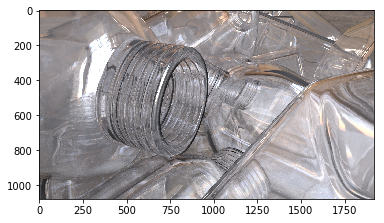

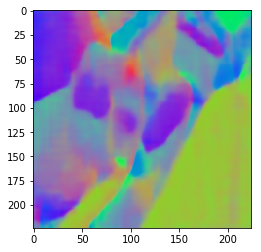

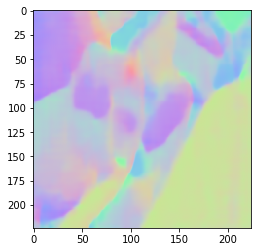

NameError: name 'exr_ground_truth_path' is not defined

In [6]:
# %matplotlib inline

import sys, os
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import models.unet_normals as unet
import numpy as np
from data_loader import Dataset,Options

class OPT():
    def __init__(self):
        self.dataroot = './data/'
        self.file_list = './data/datalist'
        self.batchSize = 24
        self.shuffle = True
        self.phase = 'eval'
        self.num_epochs = 1000
        self.imsize = 224
        self.num_classes = int(3)
        self.gpu = '0'
        self.logs_path = 'logs/exp3'

opt = OPT()
dataloader = Dataset(opt)

device = torch.device("cuda:"+ opt.gpu if torch.cuda.is_available() else "cpu")

checkpoint_path = opt.logs_path + '/checkpoints/checkpoint.pth'

# exr_ground_truth_path = 'data/000000011-normals.exr'
for i in range(0, 61):
    # Open and Transform Img
    img_not_preprocessed = Image.open('data/test-imgs/%09d-rgb.jpg'%(i)).convert("RGB")
    img = dataloader.transformImage(img_not_preprocessed)
    img = img.unsqueeze(0)

    # Send img to device
    img = Variable(img.to(device))

    # Load Model
    fcn = unet.Unet(num_classes=opt.num_classes)
    fcn.load_state_dict(torch.load(checkpoint_path))
    fcn.to(device)
    fcn.eval()

    # Inference
    res = fcn(img)
    res_norm = nn.functional.normalize(res, p=2, dim=1)
    output = res_norm.squeeze(0)
    output = output.data.cpu().numpy()
    output2 = output.copy()
    output3 = output.copy()
    print('output.shape:')
    print(output.shape)

    # Display Results
    # Orig image
    plt.imshow(img_not_preprocessed)
    plt.show()

    # Output Normals visualized with RGB
    camera_normal_rgb = dataloader.normals_to_rgb(output2)
    camera_normal_rgb = np.transpose(camera_normal_rgb, (1,2,0))
    plt.imshow(camera_normal_rgb)
    plt.show()
    plt.imsave('data/test-results/%09d-normals-result-negatives-removed.png'%(i), camera_normal_rgb)

    # Output Normals visualized with RGB, negative normal values represented
    camera_normal_rgb2 = dataloader.normal_to_rgb_with_negatives(output3)
    camera_normal_rgb2 = np.transpose(camera_normal_rgb2, (1,2,0))
    plt.imshow(camera_normal_rgb2)
    plt.show()
    plt.imsave('data/test-results/%09d-normals-result.png'%(i), camera_normal_rgb)

    # Ground Truth Normals as RGB
    truth_normal = dataloader.exr_loader(exr_ground_truth_path, ndim=3)
    truth_normal_rgb = dataloader.normals_to_rgb(truth_normal)
    truth_normal_rgb = np.transpose(truth_normal_rgb, (1,2,0))
    plt.imshow(truth_normal_rgb)
    plt.show()
    plt.imsave('data/test-results/%09d-normals-groundtruth-origsize.png'%(i), truth_normal_rgb)

    # Ground Truth Normals as RGB, with negatives and resized
    truth_normal = 0
    truth_normal_rgb = 0
    truth_normal = dataloader.exr_loader('data/test-imgs/%09d-normals.exr'%(i), ndim=3)
    
    label_tensor = torch.from_numpy(truth_normal)
    label_img = transforms.ToPILImage(mode='RGB')(label_tensor)
    label_cropped = self.transformLabel(label_img)
    label_np = label_cropped.numpy()
    
    truth_normal_rgb = dataloader.normal_to_rgb_with_negatives(label_np)
    truth_normal_rgb = np.transpose(truth_normal_rgb, (1,2,0))
    plt.imshow(truth_normal_rgb)
    plt.show()
    plt.imsave('data/test-results/%09d-normals-groundtruth.png'%(i), truth_normal_rgb)